"Two Sigma Connect: Rental Listing Inquiries" - https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/overview (Калугина Мария)
    

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn.feature_extraction.text import TfidfVectorizer
import os
import dill
import catboost as ctb
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

#from numpy.random
%matplotlib inline



In [3]:
#pip install pandas --upgrade

In [4]:
TRAIN_DATASET_PATH = './input/train.json.zip'

TEST_DATASET_PATH = './input/test.json.zip'
PREP_DATASET_PATH = '../course_project/project_train_data_prep.csv'

PIPELINE_FILE_PATH = "./models/two_sigma_pipeline.dill"



In [5]:
train_df = pd.read_json(TRAIN_DATASET_PATH).reset_index(drop = True)
test_df = pd.read_json(TEST_DATASET_PATH).reset_index(drop = True)



#### Обзор данных

In [6]:
train_df.shape

(49352, 15)

In [7]:
test_df.shape

(74659, 14)

In [8]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


In [9]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 5.6+ MB


In [10]:
train_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

In [11]:
test_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [12]:
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


#### Обзор целевой переменной

In [13]:
TARGET_NAME = 'interest_level'

In [14]:
train_df[TARGET_NAME].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

Целевая переменная принимает 3 значения, в данном случае идет речь о многоклассовой классификации

/Users/maria/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


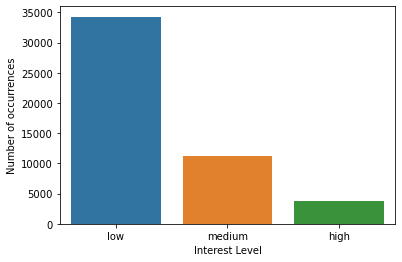

In [15]:
sns.countplot(train_df.interest_level, order=['low', 'medium', 'high']);
plt.xlabel('Interest Level');
plt.ylabel('Number of occurrences');

Видим, что классы несбалансированы. Но так как метрикой выступает logloss, балансировать их не будем

### Подготовка признаков

Удалим столбцы building_id, listing_id, street_adress - потому что они не несут смысловой нагрузки для нашей модели

In [16]:
train_df = train_df.drop(['building_id', 'listing_id'], axis=1)

In [17]:
train_df = train_df.drop('street_address', axis=1)

Конвертируем тип bathrooms и bedrooms в int

In [18]:
train_df[['bathrooms', 'bedrooms']] = train_df[['bathrooms', 'bedrooms']].astype(int)
test_df[['bathrooms', 'bedrooms']] = test_df[['bathrooms', 'bedrooms']].astype(int)

Так как фотографии недоступны - посчитаем просто количество ссылок на фото, и заменим значение в этом поле на это количество

In [19]:
train_df['photos'] = train_df.photos.apply(len)
test_df['photos'] = test_df.photos.apply(len)

In [20]:
### обрабатываем дату
train_df.created = pd.to_datetime(train_df.created, format='%Y-%m-%d %H:%M:%S')

In [21]:
### заводим новые фичи - месяц, день недели, час, год, и день
train_df['month'] = train_df.created.dt.month
train_df['day_of_week'] = train_df.created.dt.weekday
train_df['hour'] = train_df.created.dt.hour
train_df["created_year"] = train_df["created"].dt.year
train_df["created_day"] = train_df["created"].dt.day


    В результате эксперимента выяснили, что 'created' не вносит какого-либо существенного вклада в модель, так же  как и эти фичи. И поэтому при построении итоговой модели мы их брать не будем. Так же, как и 'bathrooms'.

In [22]:
train_df = train_df.drop('created', axis=1)
test_df = test_df.drop('created', axis=1)

In [23]:
train_df.head(5)

,bathrooms,bedrooms,description,display_address,features,latitude,longitude,manager_id,photos,price,interest_level,month,day_of_week,hour,created_year,created_day
0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,-73.9539,a10db4590843d78c784171a107bdacb4,12,2400,medium,6,3,5,2016,16
1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,-73.9722,955db33477af4f40004820b4aed804a0,6,3800,low,6,2,5,2016,1
2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,-73.9625,c8b10a317b766204f08e613cef4ce7a0,6,3495,medium,6,1,15,2016,14
3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,5,3000,medium,6,4,7,2016,24
4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,4,2795,low,6,1,3,2016,28


In [24]:
train_df['manager_id'].value_counts()

e6472c7237327dd3903b3d6f6a94515a    2533
6e5c10246156ae5bdcd9b487ca99d96a     711
8f5a9c893f6d602f4953fcc0b8e6e9b4     410
62b685cc0d876c3a1a51d63a0d6a8082     402
cb87dadbca78fad02b388dc9e8f25a5b     373
                                    ... 
78d5262dbc517beb7105b1dd859243e6       1
545729ea0435a0d41c5bd4fe11a374fb       1
347fb4b4e2f436e96330f0ca8bade9e3       1
fbdd56fe70632f67b031efe24563ebfd       1
cda0d536fb182dfed7cc48f0884d3203       1
Name: manager_id, Length: 3481, dtype: int64

In [25]:
NUM_FEATURES_NAMES = ['bedrooms','latitude', 'longitude','price','photos']
CAT_FEATURES_NAMES = ['manager_id'] 
TEXT_FEATURES_NAMES = ['description','features', 'display_address']

Теперь поработаем с текстовыми полями

Преобразуем в строку и переводим в нижний регистр:
    

In [26]:
train_df[TEXT_FEATURES_NAMES] = train_df[TEXT_FEATURES_NAMES].astype(str)
#To lower case
train_df[TEXT_FEATURES_NAMES] = train_df[TEXT_FEATURES_NAMES].apply(lambda x: x.str.lower())

test_df[TEXT_FEATURES_NAMES] = test_df[TEXT_FEATURES_NAMES].astype(str)
#To lower case
test_df[TEXT_FEATURES_NAMES] = test_df[TEXT_FEATURES_NAMES].apply(lambda x: x.str.lower())

убираем лишние знаки пунктуации:

In [27]:
symbols_to_replace = ['"', ',','&', '(', ')', "-", "_", ':', '=', '.', "'", '`', '!', '*', '#', '/', '<', '>', 'br',
              ';', '$', '%', '|', '+', '?','[', ']']

In [28]:
def replace_symbol(df,  symb_to_replace, replace_by):
    for symbol in symb_to_replace:
        df = df.apply(lambda x: x.str.replace(symbol, replace_by, regex = True)) 
    return df

In [29]:
train_df[TEXT_FEATURES_NAMES] = replace_symbol(train_df[TEXT_FEATURES_NAMES], symbols_to_replace, ' ')
test_df[TEXT_FEATURES_NAMES] = replace_symbol(test_df[TEXT_FEATURES_NAMES], symbols_to_replace, ' ')

Убираем лишние пробелы

In [30]:
train_df[TEXT_FEATURES_NAMES] = train_df[TEXT_FEATURES_NAMES].replace('\s+', ' ', regex = True)
train_df[TEXT_FEATURES_NAMES] = train_df[TEXT_FEATURES_NAMES].replace(['^\s', '\s$'], '', regex = True)

test_df[TEXT_FEATURES_NAMES] = test_df[TEXT_FEATURES_NAMES].replace('\s+', ' ', regex = True)
test_df[TEXT_FEATURES_NAMES] = test_df[TEXT_FEATURES_NAMES].replace(['^\s', '\s$'], '', regex = True)



In [31]:
#соберем наш простой pipeline
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    


In [32]:
final_transformers = list()

for cat_col in CAT_FEATURES_NAMES:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in NUM_FEATURES_NAMES:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for text_col in TEXT_FEATURES_NAMES:
    text_transformer = Pipeline([
                    #('imputer', TextImputer(text_col, '')),
                    ('selector', FeatureSelector(column=text_col)),
                    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2)))
                ])    
    final_transformers.append((text_col, text_transformer))

Объединим все это в единый пайплайн

In [33]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Кодируем значения целевой переменной 'interest_level'.

In [34]:
target_map = {'high':0, 'medium':1, 'low':2}
y = np.array(train_df[TARGET_NAME].apply(lambda x: target_map[x]))

In [35]:
X = train_df.drop(TARGET_NAME, axis=1)


In [36]:
frozen_params = { 'random_state':21, 'verbose':10}

Теперь соберем базовый Пайплайн

In [37]:

pipeline_catb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42,\
                                      loss_function = 'MultiClass',\
                                      classes_count = 3,thread_count = -1)),
])

Разбиваем тестовый датасет на тренировочный и валидационный

In [60]:
X_train, X_valid, y_train, y_valid =  train_test_split(
                                      X, y, test_size=0.3, stratify=y, random_state=42)



Релизуем подбор гиперпараметров с помощью кросс-валидации

params_cb={'classifier__iterations':[100,200,500,1000],
        'classifier__max_depth':[3,5,7],
        'classifier__learning_rate' : [0.05,0.1]
        }

Выделим небольшой набор данных для CV

X_train_cv, X_valid_cv, y_train_cv, y_valid_cv =  train_test_split(
                                      X_train, y_train, test_size=0.8, stratify=y_train, shuffle=True, random_state=42)

X_train_cv.head(3)

%time
grid_cb = GridSearchCV(pipeline_catb,
                    param_grid=params_cb,
                    cv=6,
                    refit=False, error_score='raise')

search_cb = grid_cb.fit(X_train_cv, y_train_cv)



search_cb.best_params_

    Создадим новый Pipeline с выбранными параметрами модели

In [66]:
pipeline_cab_result = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(**frozen_params,\
                                      reg_lambda = 5,
                                      iterations = 1000,\
                                max_depth = 5,\
                                learning_rate = 0.5,\
                                loss_function = 'MultiClass',\
                                classes_count = 3,\
                                thread_count = -1))])



In [67]:
   pipeline_cab_result.fit(X_train, y_train)
            #eval_set = Valid,

0:	learn: 0.8380401	total: 4.19s	remaining: 1h 9m 47s
10:	learn: 0.6523083	total: 35.9s	remaining: 53m 47s
20:	learn: 0.6311030	total: 1m 6s	remaining: 51m 49s
30:	learn: 0.6138204	total: 1m 37s	remaining: 50m 34s
40:	learn: 0.6030941	total: 2m 7s	remaining: 49m 46s
50:	learn: 0.5911956	total: 2m 38s	remaining: 49m 9s
60:	learn: 0.5849458	total: 3m 8s	remaining: 48m 25s
70:	learn: 0.5790185	total: 3m 39s	remaining: 47m 57s
80:	learn: 0.5741533	total: 4m 10s	remaining: 47m 17s
90:	learn: 0.5693993	total: 4m 40s	remaining: 46m 43s
100:	learn: 0.5664989	total: 5m 15s	remaining: 46m 49s
110:	learn: 0.5633916	total: 5m 48s	remaining: 46m 32s
120:	learn: 0.5607189	total: 6m 18s	remaining: 45m 51s
130:	learn: 0.5580001	total: 6m 49s	remaining: 45m 14s
140:	learn: 0.5552953	total: 7m 19s	remaining: 44m 38s
150:	learn: 0.5528952	total: 7m 48s	remaining: 43m 55s
160:	learn: 0.5498523	total: 8m 17s	remaining: 43m 14s
170:	learn: 0.5480486	total: 8m 46s	remaining: 42m 33s
180:	learn: 0.5458116	tot

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('manager_id',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='manager_id')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='manager_id'))])),
                                                ('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('latitude',
                                                 Pipeline(steps=[('selector',
           

In [68]:
y_valid_pred_proba = pipeline_cab_result.predict_proba(X_valid)

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

In [69]:
from sklearn.metrics import log_loss
>>> log_loss(y_valid, y_valid_pred_proba)

0.5945087508842136

In [70]:
model_dict = {
    'model':pipeline_cab_result,\
    'version':'0.0.1'
    
}

In [71]:
with open(PIPELINE_FILE_PATH, "wb") as f:
    dill.dump(model_dict, f)

In [72]:
y_test = pipeline_cab_result.predict_proba(test_df)

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-ab6621e28e5e>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col_] = 0
<ipython-input-31-a

In [73]:
test_df

,bathrooms,bedrooms,building_id,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1,1,79780be1514f645d7e6be99a3de696c5,large with awesome terrace accessible via bedr...,suffolk street,elevator laundry in building laundry in unit d...,40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,8,2950,99 Suffolk Street
1,1,2,0,prime soho between bleecker and houston newly ...,thompson street,pre war dogs allowed cats allowed,40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,3,2850,176 Thompson Street
2,1,0,0,spacious studio in prime location cleanbuildin...,sullivan street,pre war dogs allowed cats allowed,40.7260,7174566,-74.0026,e6472c7237327dd3903b3d6f6a94515a,1,2295,115 Sullivan Street
3,1,2,f9c826104b91d868e69bd25746448c0c,for immediate access call yan bond new york is...,jones street,hardwood floors dogs allowed cats allowed,40.7321,7191391,-74.0028,41735645e0f8f13993c42894023f8e58,4,2900,23 Jones Street
4,1,1,81062936e12ee5fa6cd2b965698e17d5,beautiful true 1 bedroom in a luxury building ...,exchange place,roof deck doorman elevator fitness center pre ...,40.7054,7171695,-74.0095,a742cf7dd3b2627d83417bc3a1b3ec96,6,3254,20 Exchange Place
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74654,1,1,bd863d28a6b119ac3bc72d5f27b07f24,and new to market 1bdr 107th and lexington sec...,150 east 107th street,,40.7925,6928108,-73.9454,453d46f8113e1f2c730c2ee5a4469c71,10,1700,158 EAST 107TH STREET
74655,1,2,9174b75c0cd978eb0e5aa93afbad754b,convertible 2 apartment features a and new mar...,e 33rd st,doorman elevator laundry in building dishwashe...,40.7456,6906674,-73.9797,2983e45f7e0ad87d677dacd13e362785,4,4195,141 E 33rd St.
74656,1,0,0,let s get you in to see this 2 400 mo recently...,lexington avenue,dogs allowed cats allowed,40.7416,6897967,-73.9829,e6472c7237327dd3903b3d6f6a94515a,0,2400,95 Lexington Avenue
74657,2,2,c90c010e5505365676538e64d02aa1e0,coopercooper com web id 171357 access 1000s of...,park avenue,doorman elevator cats allowed dogs allowed,40.7485,6842183,-73.9800,6e5c10246156ae5bdcd9b487ca99d96a,8,6895,41 Park Avenue


In [74]:
target_map = {'high':0, 'medium':1, 'low':2}

In [75]:
submission = pd.DataFrame()
submission["listing_id"] = test_df["listing_id"]
for label in ["high", "medium", "low"]:
    submission[label] = y_test[:, target_map[label]]


In [ ]:
submission.to_csv("submission.csv", index=False)